This is a notebook for my data mining class project. \
My goal is to train a neural network with data from professional counterstrike matches in order to predict fantasy player line ups. \
</br>
Initially, I wanted to use an LSTM. I was thinking this would be good to use because it might be able to account for the ups and downs a player experiences throughout their career. Like how they might have a great performance in one tournament and a horrible one in the next. However, I am realizing I don't really understand neural networks. I think in order to use an LSTM, I need time series data, which I was thinking I had because the matches in the database are in chronological order. But I think it needs to be like at a certain time, I got this value, so at the next time what value will i get. there is no next time in this data, so I need a different NN. \
</br>
Next, I decided to just use a NN, I don't know if there is a specific name. I initially tried with a feature vector where every example corresponded to a single match. 10 features were the 10 players that played in that game and we wanted to predict the 11th feature, which was the player with the highest kddiff. I think this didn't work because you need to scale data between 0-1 for NNs and then it is hard to get the playerIDs back. \
</br>
So now I am trying it where 

I start with importing data from player.csv \
I am not interested in all the data so I specified what data I want with the fields list.

In [223]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense
import matplotlib.pyplot

# Specify which columns from players.csv you want
fields = ['player_name','player_id','match_id','m1_kddiff']

# Read in those columns
data = pd.read_csv('players.csv', usecols=fields)

# Here we see what the data looks like
print(data)


       player_name  player_id  match_id  m1_kddiff
0           Brehze       9136   2339385         -7
1             CeRq      11219   2339385         -6
2            EliGE       8738   2339385          3
3            Ethan      10671   2339385         -4
4              NAF       8520   2339385         -2
...            ...        ...       ...        ...
383312      kIMERA       7607   2298497         11
383313   morphiw0w       9752   2298497          8
383314     overfly       7698   2298497         -8
383315     simozor       9753   2298497        -12
383316       xullE       9754   2298497        -11

[383317 rows x 4 columns]


I noticed the most recent games were first in the list, but I want them last so I reverse order

In [224]:
# I want the first games to appear first in the data frame
data = data.loc[::-1].reset_index(drop=True)
print(data)

       player_name  player_id  match_id  m1_kddiff
0            xullE       9754   2298497        -11
1          simozor       9753   2298497        -12
2          overfly       7698   2298497         -8
3        morphiw0w       9752   2298497          8
4           kIMERA       7607   2298497         11
...            ...        ...       ...        ...
383312         NAF       8520   2339385         -2
383313       Ethan      10671   2339385         -4
383314       EliGE       8738   2339385          3
383315        CeRq      11219   2339385         -6
383316      Brehze       9136   2339385         -7

[383317 rows x 4 columns]


In [225]:
# Ask which player's kd we want to predict (case sensitive)
inp = input("Which player's kd would you like to predict?")
print(inp)

karrigan


In [226]:
# This checks if the input name is in the database
inp in data["player_name"].unique()

True

In [227]:
# This shows the player id of the input player
data.loc[data['player_name'] == inp, 'player_id'].iloc[0]

429

In [292]:
print(min(data["m1_kddiff"]))

-26


In [228]:
# Now we combine the two above cells to save the player id or print error message
if  inp in data["player_name"].unique():
    selectedPlayerID = data.loc[data['player_name'] == inp, 'player_id'].iloc[0]
else:
    print("player not in database, please try again")
print(selectedPlayerID)

429


^^Add proper error handling for when player name not in dataframe^^

In [229]:
# number of features is equal to the number of unique player ids
numFeatures = len(data["player_id"].unique())
print(numFeatures)

# number of examples is equal to the number of matches the selected player played in
numMatches = len(data.loc[data['player_name'] == inp, 'player_id'])

print(numMatches)
features = [ [0 for _ in range(numFeatures + 1)] for _ in range(numMatches)]
features = np.array(features)
print(np.shape(features))
print(numMatches)


12295
693
(693, 12296)
693


In [230]:
# this makes a dataframe of the matches the selected player played in
selectedPlayerData = data.loc[data["player_id"] == selectedPlayerID]
print(selectedPlayerData)

       player_name  player_id  match_id  m1_kddiff
181       karrigan        429   2298502          2
690       karrigan        429   2298584          0
789       karrigan        429   2298573         18
890       karrigan        429   2298575          3
1019      karrigan        429   2298602         -1
...            ...        ...       ...        ...
377923    karrigan        429   2339156         -1
378494    karrigan        429   2339162          1
378662    karrigan        429   2339164         -7
382751    karrigan        429   2339503         13
383291    karrigan        429   2339384        -14

[693 rows x 4 columns]


In [231]:
# all match ids selected player played in
selectedPlayerData["match_id"].unique()

array([2298502, 2298584, 2298573, 2298575, 2298602, 2298612, 2298613,
       2298639, 2298640, 2298648, 2298688, 2298719, 2298724, 2298726,
       2298755, 2298781, 2298783, 2298789, 2298817, 2298854, 2298839,
       2298876, 2298877, 2298925, 2298950, 2298973, 2298999, 2299000,
       2299002, 2299348, 2299340, 2299344, 2299361, 2299438, 2299466,
       2299471, 2299501, 2299525, 2299541, 2299587, 2299625, 2299622,
       2299674, 2299696, 2299762, 2299801, 2299842, 2299866, 2299974,
       2300197, 2300210, 2300244, 2300245, 2300276, 2300295, 2300297,
       2300316, 2300414, 2300428, 2300439, 2300592, 2300594, 2300634,
       2300637, 2300655, 2300656, 2300663, 2300664, 2300804, 2300805,
       2300881, 2300883, 2300914, 2300916, 2300933, 2300935, 2300937,
       2300938, 2301005, 2301006, 2301043, 2301160, 2301162, 2301167,
       2301169, 2301172, 2301186, 2301095, 2301096, 2301108, 2301109,
       2301114, 2301115, 2301439, 2301455, 2301456, 2301382, 2301383,
       2301525, 2301

In [232]:
# Now to assign each player a new index for the feature vector, I first sort the dataframe by player_id
sortedData = data.sort_values(by=['player_id'])
print(sortedData)

       player_name  player_id  match_id  m1_kddiff
25269       RobbaN          2   2301373        -10
22964       RobbaN          2   2301097         -1
29179        Friis          7   2301937         -3
17261        Friis          7   2300544         -1
13257        Friis          7   2299933         10
...            ...        ...       ...        ...
382558      rabbit      20006   2339750          6
382594     boskacz      20007   2339745        -13
383201       Porky      20009   2339813         -2
383197       shevi      20010   2339813        -11
383163      bichop      20011   2339810         -6

[383317 rows x 4 columns]


In [233]:
# Now I add a new column to the dataframe that will correspond to the players feature vector index
sortedData['featureIndex'] = 0
print(sortedData)

       player_name  player_id  match_id  m1_kddiff  featureIndex
25269       RobbaN          2   2301373        -10             0
22964       RobbaN          2   2301097         -1             0
29179        Friis          7   2301937         -3             0
17261        Friis          7   2300544         -1             0
13257        Friis          7   2299933         10             0
...            ...        ...       ...        ...           ...
382558      rabbit      20006   2339750          6             0
382594     boskacz      20007   2339745        -13             0
383201       Porky      20009   2339813         -2             0
383197       shevi      20010   2339813        -11             0
383163      bichop      20011   2339810         -6             0

[383317 rows x 5 columns]


In [234]:
playerFeatureIndex = 1
prevPlayer = sortedData['player_id'].iloc[0]
for index, row in sortedData.iterrows():
    currentPlayer  = row["player_id"]
    if currentPlayer == prevPlayer:
        sortedData.loc[index, 'featureIndex'] = playerFeatureIndex
    else:
        playerFeatureIndex = playerFeatureIndex + 1
        sortedData.loc[index, 'featureIndex'] = playerFeatureIndex
        prevPlayer = currentPlayer
print(sortedData)


       player_name  player_id  match_id  m1_kddiff  featureIndex
25269       RobbaN          2   2301373        -10             1
22964       RobbaN          2   2301097         -1             1
29179        Friis          7   2301937         -3             2
17261        Friis          7   2300544         -1             2
13257        Friis          7   2299933         10             2
...            ...        ...       ...        ...           ...
382558      rabbit      20006   2339750          6         12291
382594     boskacz      20007   2339745        -13         12292
383201       Porky      20009   2339813         -2         12293
383197       shevi      20010   2339813        -11         12294
383163      bichop      20011   2339810         -6         12295

[383317 rows x 5 columns]


In [235]:
data = sortedData.sort_index()
print(sortedData)

       player_name  player_id  match_id  m1_kddiff  featureIndex
25269       RobbaN          2   2301373        -10             1
22964       RobbaN          2   2301097         -1             1
29179        Friis          7   2301937         -3             2
17261        Friis          7   2300544         -1             2
13257        Friis          7   2299933         10             2
...            ...        ...       ...        ...           ...
382558      rabbit      20006   2339750          6         12291
382594     boskacz      20007   2339745        -13         12292
383201       Porky      20009   2339813         -2         12293
383197       shevi      20010   2339813        -11         12294
383163      bichop      20011   2339810         -6         12295

[383317 rows x 5 columns]


In [236]:
print(data)

       player_name  player_id  match_id  m1_kddiff  featureIndex
0            xullE       9754   2298497        -11          2235
1          simozor       9753   2298497        -12          2234
2          overfly       7698   2298497         -8          1015
3        morphiw0w       9752   2298497          8          2233
4           kIMERA       7607   2298497         11           982
...            ...        ...       ...        ...           ...
383312         NAF       8520   2339385         -2          1375
383313       Ethan      10671   2339385         -4          3134
383314       EliGE       8738   2339385          3          1517
383315        CeRq      11219   2339385         -6          3676
383316      Brehze       9136   2339385         -7          1789

[383317 rows x 5 columns]


In [265]:
i = -1
prevMatch = 0
# for each entry in the dataframe
for index, row in data.iterrows():
    currentMatch  = row["match_id"]
    # check if the match id of the current entry is one of the matches the selected player played in and make sure it is not the selected player
    if currentMatch in selectedPlayerData["match_id"].unique():
        # check currentMatch vs prevMatch
        if currentMatch != prevMatch:
            i = i + 1
        # set the player id to 1 for the current player
        player = row['featureIndex']
        features[i, player] = 1
        # need to store the selected player's kd from this game somewhere
        if row["player_id"] == selectedPlayerID:
            features[i, 0] = row['m1_kddiff']
    prevMatch = currentMatch
print(np.shape(features))

(693, 12296)


In [266]:
print(features)

[[  2   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [ 18   0   0 ...   0   0   0]
 ...
 [ -7   0   0 ...   0   0   0]
 [ 13   0   0 ...   0   0   0]
 [-14   0   0 ...   0   0   0]]


so now I want to split the data set into an x and y, then split those two into test and training.
in one video im wathching he doesnt seperate the data, just creates the 

Epoch 1/5
20/20 [==============================] - 0s 4ms/step - loss: 1.4337
Epoch 2/5
20/20 [==============================] - 0s 4ms/step - loss: 1.4103
Epoch 3/5
20/20 [==============================] - 0s 4ms/step - loss: 1.3883
Epoch 4/5
20/20 [==============================] - 0s 4ms/step - loss: 1.3668
Epoch 5/5
3/3 [==============================] - 0s 3ms/step
Epoch 1/5
20/20 [==============================] - 0s 4ms/step - loss: 1.1752
Epoch 2/5
20/20 [==============================] - 0s 4ms/step - loss: 1.1676
Epoch 3/5
20/20 [==============================] - 0s 5ms/step - loss: 1.1605
Epoch 4/5
20/20 [==============================] - 0s 4ms/step - loss: 1.1534
Epoch 5/5
3/3 [==============================] - 0s 3ms/step
Epoch 1/5
20/20 [==============================] - 0s 4ms/step - loss: 1.0413
Epoch 2/5
20/20 [==============================] - 0s 4ms/step - loss: 1.0359
Epoch 3/5
20/20 [==============================] - 0s 4ms/step - loss: 1.0306
Epoch 4/5
20/20 [===

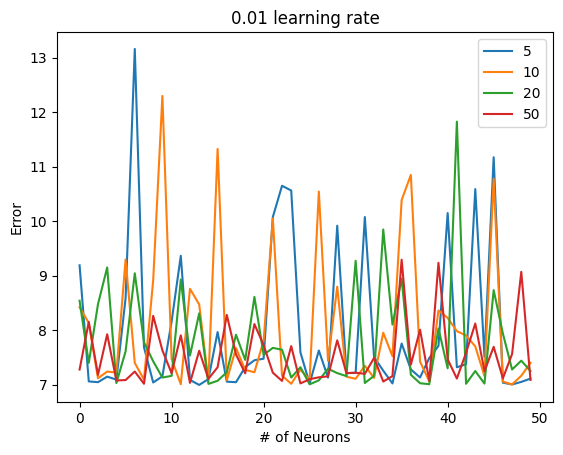

In [290]:
import matplotlib.pyplot as plt
import math
# separate ys from x
x = features[:,1:]
y = features[:,0]
y = y.reshape(-1,1)
epochs = [5, 10, 20, 50]
errors = [[0.000 for _ in range(len(epochs))] for _ in range(50)]
errors = np.array(errors)
i=0
for epoch in epochs:
    for j in range(50):    
        ### Standardization of data ###
        from sklearn.preprocessing import StandardScaler
        yScaler=StandardScaler()
        # Storing the fit object for later reference
        yScalerFit=yScaler.fit(y)
        # Generating the standardized values of X and y
        y_trans=yScalerFit.transform(y)
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(x, y_trans, test_size=0.1, shuffle=False)
        model = keras.Sequential()
        model.add(keras.Input(shape=(numFeatures)))
        model.add(layers.Dense(3, activation="sigmoid"))
        model.add(layers.Dense(1, activation="linear"))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
        model.fit(x_train, y_train, batch_size=32, epochs=epoch)
        y_pred = model.predict(x_test)
        y_pred=yScalerFit.inverse_transform(y_pred)
        y_test=yScalerFit.inverse_transform(y_test)
        from sklearn.metrics import mean_squared_error
        error = mean_squared_error(y_test,y_pred)
        import math
        errors[j, i] = math.sqrt(error)
    
    i=i+1
lines = plt.plot(errors)
plt.legend(lines, ('5', '10', '20', '50'))
plt.title("0.01 learning rate")
plt.xlabel("# of Neurons")
plt.ylabel("Error")
plt.show()


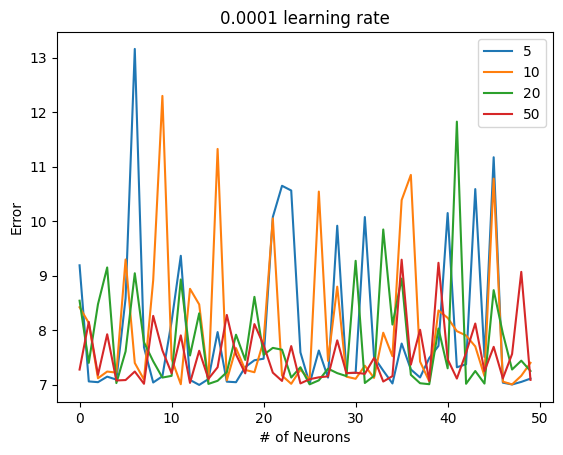

In [291]:
lines = plt.plot(errors)
plt.legend(lines, ('5', '10', '20', '50'))
plt.title("0.0001 learning rate")
plt.xlabel("# of Neurons")
plt.ylabel("Error")
plt.show()

In [270]:
print(errors)

[[7 8 8 8 8 8 8]
 [7 7 8 8 8 8 8]
 [8 8 8 8 8 8 9]]


In [ ]:
import matplotlib.pyplot as plt
plt.plot(error)
plt.show()

In [210]:
activations = ["sigmoid", "elu"]
neurons = [5, 10, 15, 25]
learningRates = [0.1, 0.01, 0.001]
epochs = [5, 10]
errors = [[[[0 for _ in range(len(activations))] for _ in range(len(neurons))] for _ in range(len(learningRates))] for _ in range(len(epochs))]
errors = np.array(errors)
i = 0
for activation in activations:
    j = 0
    for neuron in neurons:
        k = 0
        for learningRate in learningRates:
            m = 0
            for epoch in epochs:
                model = keras.Sequential()
                model.add(keras.Input(shape=(numFeatures)))
                model.add(layers.Dense(neuron, activation=activation))
                model.add(layers.Dense(1, activation="linear"))
                #model.summary()
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=learningRate), loss="mse")
                model.fit(x_train, y_train, batch_size=32, epochs=epoch)
                y_pred = model.predict(x_test)
                from sklearn.metrics import mean_squared_error
                errors[m,k,j,i] = mean_squared_error(y_test,y_pred)
                m = m + 1
            k = k + 1
        j = j + 1
    i = i + 1

Epoch 1/5
20/20 [==============================] - 0s 2ms/step - loss: 1.0359
Epoch 2/5
20/20 [==============================] - 0s 2ms/step - loss: 0.9077
Epoch 3/5
20/20 [==============================] - 0s 2ms/step - loss: 0.8264
Epoch 4/5
20/20 [==============================] - 0s 2ms/step - loss: 0.7928
Epoch 5/5
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
20/20 [==============================] - 0s 2ms/step - loss: 1.1034
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.9204
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.8317
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.7847
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 0.7236
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.7006
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 0.7094
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: 0.

In [211]:
print(errors)

[[[[60 60]
   [59 58]
   [58 60]
   [60 60]]

  [[59 59]
   [58 61]
   [59 60]
   [59 60]]

  [[59 59]
   [59 59]
   [59 59]
   [59 59]]]


 [[[60 59]
   [58 60]
   [60 59]
   [60 57]]

  [[60 61]
   [60 60]
   [60 60]
   [60 60]]

  [[59 59]
   [59 59]
   [59 60]
   [59 59]]]]


======================================================================================================================================== \
Code below here is old / obsolete. \
It is I wrote for creating an old feature matrix. \
In this feature matrix, every example corresponds to a single match from the players.csv dataset, and features are the player id of every player in the match and the player id of the player with the largest kddiff in the match. I was hoping to feed this data into a neural network that could then predict the player that would get the largest kddiff when given the 10 players. Im not sure if this would even work conceptually \

========================================================================================================================================

In [ ]:
print(len(data["match_id"].unique()))
OLDnumMatches = len(data["match_id"].unique())
OLDnumFeatures = 12
features = [ [0 for _ in range(OLDnumFeatures)] for _ in range(OLDnumMatches)]
kddiff = [ 0 for _ in range(10)]
features = np.array(features)
kddiff = np.array(kddiff)
print(features)
print(kddiff)

In [ ]:
zeros = [ 0 for _ in range(10)]
zeros = np.array(zeros)
kddiff = zeros
print(kddiff)

In [ ]:
i= 0
j= 0
prevMatch = data['match_id'].iloc[0]
# for every input in the dataframe
for index, row in data.iterrows():
    #we store the match ID of the current row
    currentMatch  = row["match_id"]
#we then compare the current and previous match ID
    # If they are the same
    if currentMatch == prevMatch:
        # we store the current player ID and their kddiff, then move j over one for the next player in the match
        features[i,j] = row["player_id"]
        kddiff[j]     = row["m1_kddiff"]
        j = j + 1
    # If they are not the same, we are looking at a new/different match, this means we have all the data from the previous match
    else:
        # So now we can find the best kddiff of the match and which player had that kddiff
        features[i,10] = max(kddiff)
        features[i,11] = features[i,pd.Series(kddiff).idxmax()]
        # now we move to a new match, so we increase i
        i = i + 1
        #and reset j and kddiff array
        j = 0
        kddiff = zeros
        #store current player and their kddiff
        features[i,j] = row["player_id"]
        kddiff[j]     = row["m1_kddiff"]
        #update previous match to current match
        prevMatch = currentMatch
        j = 1

features[numMatches-1,10] = max(kddiff)
features[numMatches-1,11] = features[numMatches-1,pd.Series(kddiff).idxmax()]

In [ ]:
# checking data was moved correctly
print(features[numMatches-1,:])
data.tail(10)

